In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import MultiPolygon, Polygon, Point, shape
import json
from datetime import date
import re

# Load the Data Set for Manhattan

In [2]:
# Connect to the database
database = "/Users/zachcuddihy/Projects/apartment_scraper/data/apartments.db"
conn = create_connection(database)
c = conn.cursor()

In [3]:
query = f"""SELECT * FROM units
            JOIN properties
            USING (property_name)
            WHERE city_name='Brooklyn';
"""

units = pd.read_sql_query(query, conn)
conn.close()

# Correct the dishwasher column to 1s and zeros only
units.dishwasher = np.where(units.dishwasher == 'True',
                            1,
                            units.dishwasher)
units.dishwasher = np.where(units.dishwasher == 'False',
                            0,
                            units.dishwasher)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url
0,The Brooklyner,11201,1-06K,4060,1,1,684,2022-05-06,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
1,The Brooklyner,11201,1-06K,4060,1,1,684,2022-05-06,2022-04-11,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
2,The Brooklyner,11201,1-07D,3005,0,0,469,2022-04-20,2022-04-19,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
3,The Brooklyner,11201,1-09H,5122,2,2,976,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
4,The Brooklyner,11201,1-09H,5122,2,2,976,2022-04-11,2022-04-11,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...


In [4]:
# Drop duplicate unit listings 
units.drop_duplicates(['property_name', 'unit_id', 'property_zipcode'], keep='last', inplace=True)

In [5]:
units.dtypes

property_name           object
property_zipcode        object
unit_id                 object
rent                    object
beds                    object
baths                   object
sqft                    object
date_available          object
date_scraped            object
fitness_center           int64
air_conditioning         int64
in_unit_washer_dryer     int64
laundry_facilities       int64
car_charging             int64
roof                     int64
concierge                int64
pool                     int64
elevator                 int64
garage                   int64
dogs_allowed             int64
cats_allowed             int64
income_restrictions      int64
latitude                object
longitude               object
neighborhood            object
zipcode                 object
description             object
unique_features         object
city_name               object
year_built              object
dishwasher              object
property_url            object
dtype: o

In [6]:
pd.concat([units.isnull().sum(),units.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
property_name,0,0
property_zipcode,0,0
unit_id,0,0
rent,0,3
beds,0,0
baths,0,0
sqft,0,514
date_available,0,0
date_scraped,0,0
fitness_center,0,0


In [7]:
# Remove all units without square feet or rent values
# It's possible to impute these missing values
# but likely will skew any results that are generated
units = units[units.sqft != '']
units = units[units.rent != '']

In [8]:
units.rent=units.rent.astype(float)
units.sqft=units.sqft.astype(float)
units.beds=units.beds.astype(int)
units.baths=units.baths.astype(float)
units.latitude=units.latitude.astype(float)
units.longitude=units.longitude.astype(float)
units.date_available=units.date_available.astype('datetime64[ns]')
units.date_scraped=units.date_scraped.astype('datetime64[ns]')

# Plot the data points to visualize the apartment locations

In [9]:
fig = px.scatter_mapbox(units,
              lat="latitude" ,
              lon="longitude",
              hover_name="property_name",
              mapbox_style='carto-positron',    
              zoom=10)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Explore any possible outliers

In [10]:
# Descriptive stats based on setting a specific target column
def descriptive_stats(target,df):
    average = df.groupby('beds', as_index=True)[target].mean()
    ci_5 = df.groupby('beds', as_index=True)[target].quantile(0.05)    #5th Percentile
    ci_95 = df.groupby('beds', as_index=True)[target].quantile(0.95)   #95th Percentile
    minimum= df.groupby('beds', as_index=True)[target].min()
    maximum = df.groupby('beds', as_index=True)[target].max()
    std = df.groupby('beds', as_index=True)[target].std()
    num = df.groupby('beds', as_index=True)[target].count()
    
    stats_df = pd.DataFrame({f'Average {target}':average, 
                            '5th Percentile':ci_5,
                            '95th Percentile':ci_95,
                            'Minimum':minimum, 
                            'Maximum':maximum,
                            'Standard Deviation':std,
                            'Number of Units': num})
    
    stats_df.reset_index(inplace=True)
    return stats_df

In [11]:
# Add a price/sqft column that will be useful for visualization and detecting outliers
units['price/sqft'] = units.rent / units.sqft

In [12]:
# Get the descriptive stats for the price/sqft column
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,10.046304,2.288333,17.825926,1.552632,67.840000,11.975458,154
1,1,5.343108,1.759091,7.101364,0.596026,86.760000,11.359090,249
2,2,4.098118,1.900000,6.236031,0.641849,153.240000,10.728644,367
3,3,2.917658,1.666935,4.471768,0.641026,6.949270,0.878115,331
4,4,3.501047,1.979400,5.727273,0.295730,10.833333,1.539070,113
5,5,3.041027,2.182046,3.737500,1.891892,4.000000,0.539766,19
6,6,3.266719,2.806667,4.012500,2.700000,4.285714,0.501136,7


* We can see that there are very few instances of 4, 5 and 6 bedroom options. Those will need to be dropped as there isn't sufficent data. 
* There seems to be sever very large values in each bed column that are skewing the data set. The 95th percentile is roughly $8-10/sqft where as the standard deviations are much larger than that. We'll start by capping the price/sqft at $20 then further examining the data. 

In [13]:
# Drop the 4, 5 and 6 bedroom units since they make up a small portion of the dataset
units = units[units.beds < 4]
units = units[units['price/sqft'] < 20]
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,7.720747,2.276667,15.517284,1.552632,17.938272,4.359522,147
1,1,3.736942,1.753409,6.931895,0.596026,9.423077,1.606973,244
2,2,3.311259,1.900000,6.187240,0.641849,8.546154,1.281329,365
3,3,2.917658,1.666935,4.471768,0.641026,6.949270,0.878115,331


Lets further visualize the distribution of the rent and sqft for each bedroom to verify no further outliers remain. 

In [14]:
def outlier_plot(beds:int, target: str):
    # Main plot
    f, ax = plt.subplots(figsize = (12,12))
    ax = sns.histplot(x=units[units.beds == beds][target], kde=True)
    
    # Add outlier bands
    lower_std = units[units.beds == beds][target].mean() - 2*units[units.beds == beds][target].std()
    upper_std = units[units.beds == beds][target].mean() + 2*units[units.beds == beds][target].std()
    lower_quan = units[units.beds == beds][target].quantile(0.025)
    upper_quan = units[units.beds == beds][target].quantile(0.975)
    
    #Plot upper and lower based bands
    ax.axvline(lower_std, color='red', ls='-', alpha=0.4, lw=10)
    ax.axvline(upper_std, color='red', ls='-', alpha=0.4, lw=10)
    ax.axvline(lower_quan, color='green', ls='-', alpha=0.4, lw=10)
    ax.axvline(upper_quan, color='green', ls='-', alpha=0.4, lw=10)
    ax.set_title(f'Outlier Visualization: {beds} bedrooms versus {target}', fontsize=15)

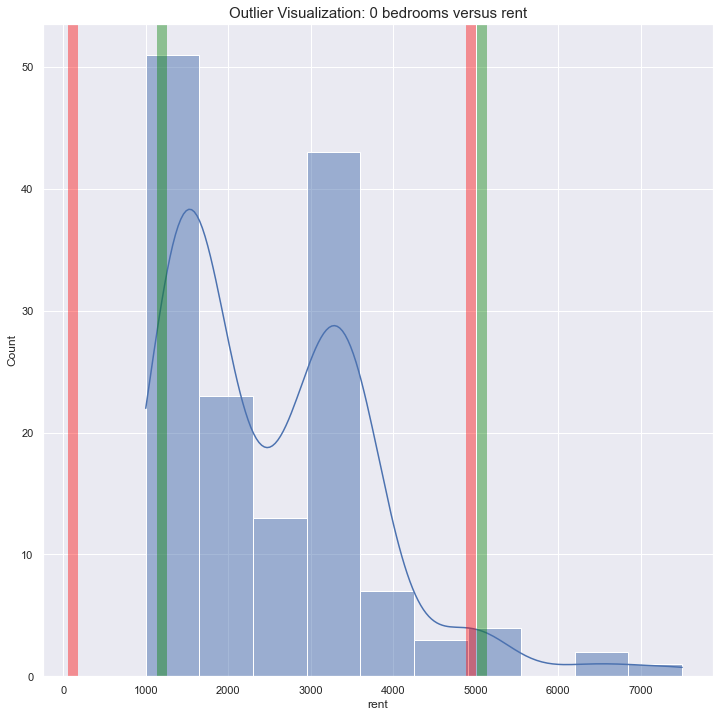

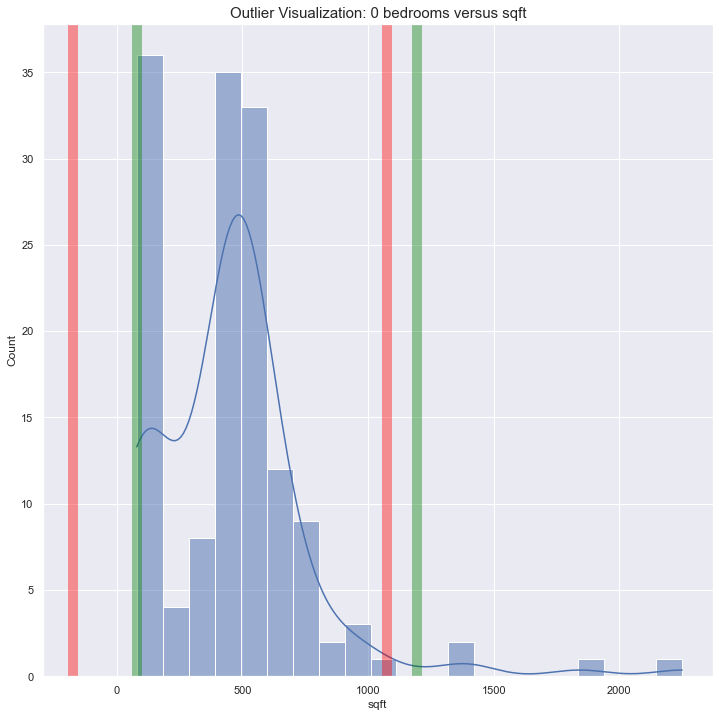

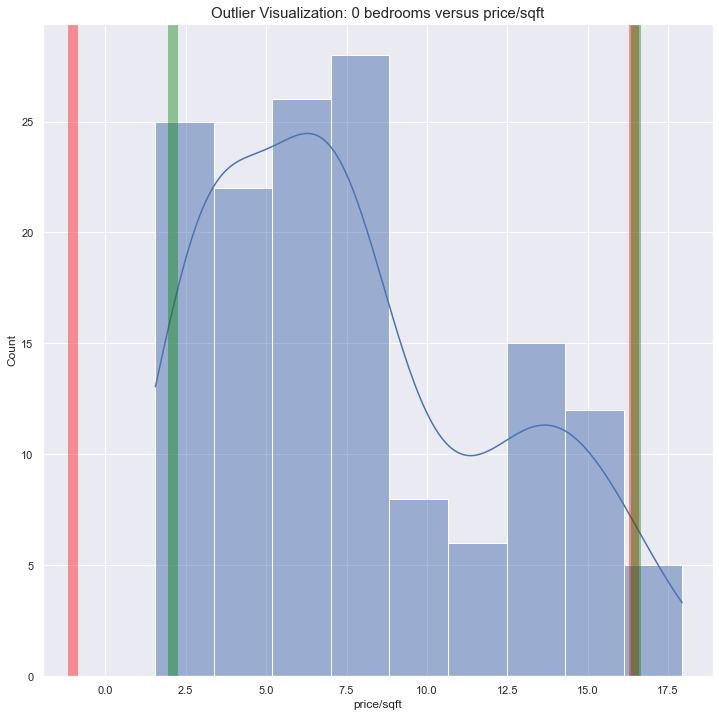

In [15]:
# Outlier plots for studios
outlier_plot(0,'rent')
outlier_plot(0,'sqft')
outlier_plot(0,'price/sqft')

In [16]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>1500) & (units.beds==0)].index, inplace=True)
units.drop(units[(units.rent>5000) & (units.beds==0)].index, inplace=True)

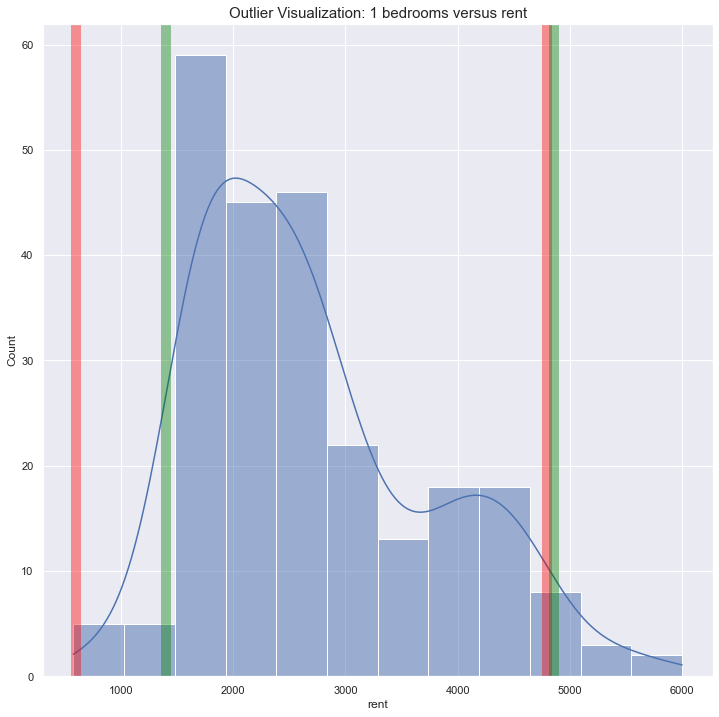

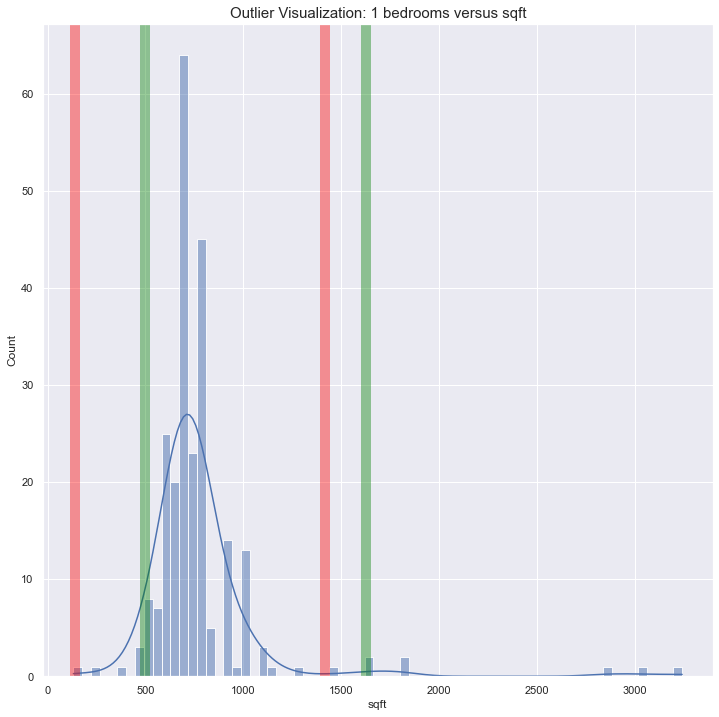

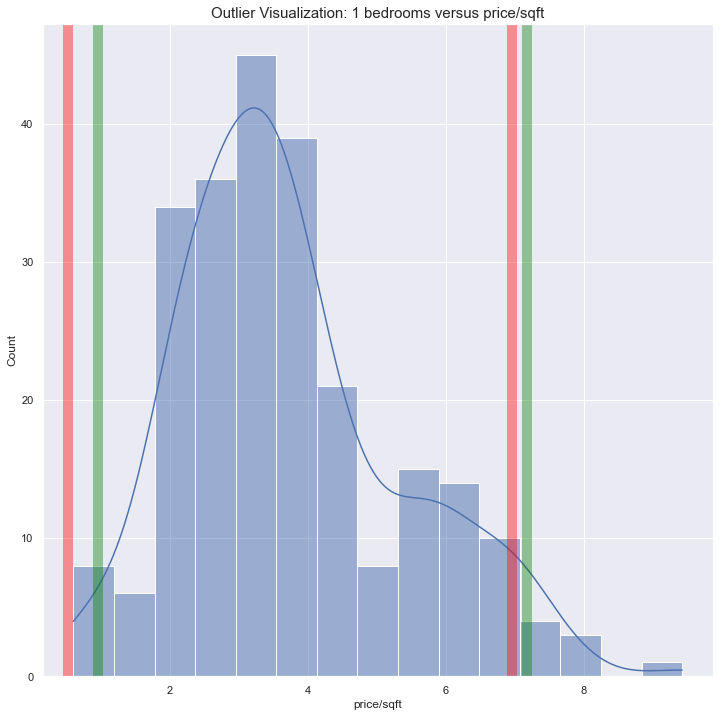

In [17]:
# Outlier plots for studios
beds = 1
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

According to the price/sqft plot, the data looks fairly reasonably so we'll explore the few data points that appears to be an outliers.

In [18]:
units[(units.beds == 1) & (units.sqft >1500)]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft
233,976 Fulton St,11238,976 Fulton St 5B,3241.0,1,1.0,3241.0,2022-04-05,2022-04-05,1,...,-73.96184,Clinton Hill,11238,Beautiful 7 Storie elevator building with stun...,,Brooklyn,2016,1,https://www.apartments.com/976-fulton-st-brook...,1.000000
577,1893 Pacific St,11233,1,2750.0,1,1.0,1640.0,2022-04-11,2022-04-11,0,...,-73.92621,Weeksville,11233,BRAND NEW FURNISHED HUGE 1BEDROOM/ 1 BATHROOM ...,,Brooklyn,NULL,1,https://www.apartments.com/1893-pacific-st-bro...,1.676829
579,1893 Pacific St,11233,2,2750.0,1,1.0,1650.0,2022-04-11,2022-04-11,0,...,-73.92621,Weeksville,11233,BRAND NEW FURNISHED HUGE 1BEDROOM/ 1 BATHROOM ...,,Brooklyn,NULL,1,https://www.apartments.com/1893-pacific-st-bro...,1.666667
886,9502 Foster Ave,11236,9502 Foster Ave,1800.0,1,1.0,3020.0,2022-04-19,2022-04-19,1,...,-73.90716,Canarsie,11236,"Canarsie1 Bedroom apartment with EIK , Living ...",,Brooklyn,NULL,1,https://www.apartments.com/9502-foster-ave-bro...,0.596026
3384,1337 Saint Marks Ave,11233,1337 Saint Marks Ave,1975.0,1,1.0,2850.0,2022-05-01,2022-04-19,0,...,-73.92406,Weeksville,11233,"Large, Renovated kitchen with stainless steel ...",,Brooklyn,NULL,1,https://www.apartments.com/1337-saint-marks-av...,0.692982
3716,2318 Brigham St,11229,1Fl,1500.0,1,1.0,1800.0,2022-04-19,2022-04-19,0,...,-73.93459,Sheepshead Bay,11229,2318 Brigham St is an apartment located inKing...,,Brooklyn,NULL,0,https://www.apartments.com/2318-brigham-st-bro...,0.833333
3717,2318 Brigham St,11229,2318 Brigham St,1500.0,1,1.0,1800.0,2022-04-19,2022-04-19,0,...,-73.93459,Sheepshead Bay,11229,2318 Brigham St is an apartment located inKing...,,Brooklyn,NULL,0,https://www.apartments.com/2318-brigham-st-bro...,0.833333


From the looks of it, these all appear to be realistic apartments as they represent some of the luxury properties that people can rent. However, they make up a fraction of the data set and won't necessarily be useful data points for our model. 

In [19]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>1500) & (units.beds==1)].index, inplace=True)
units.drop(units[(units.rent>7000) & (units.beds==1)].index, inplace=True)

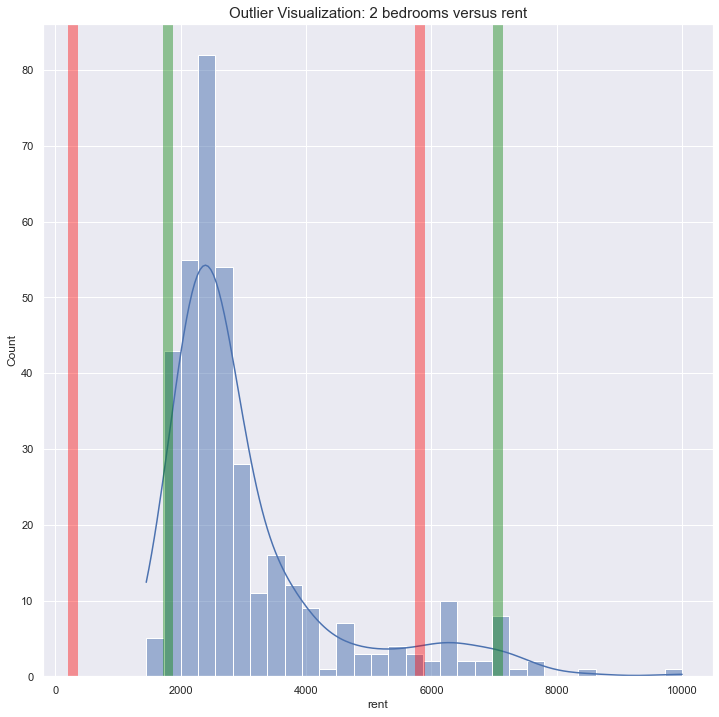

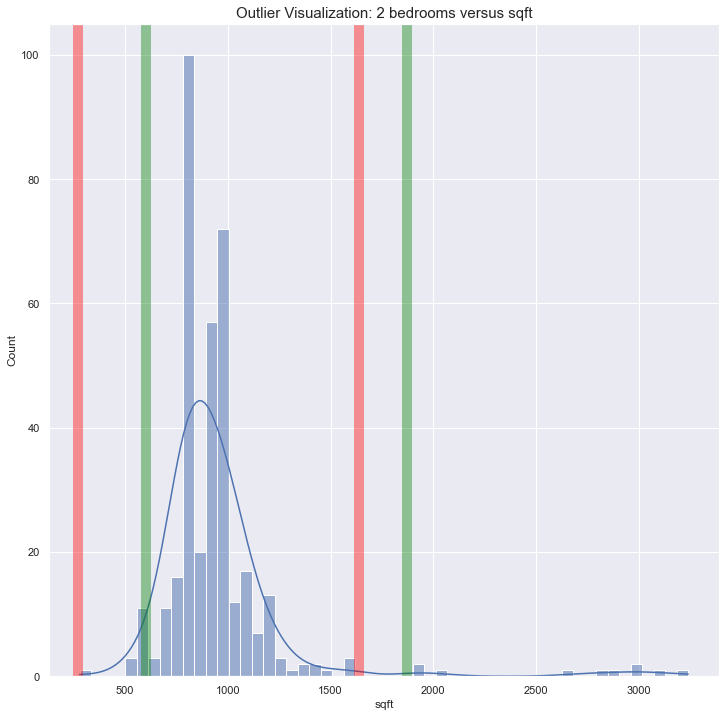

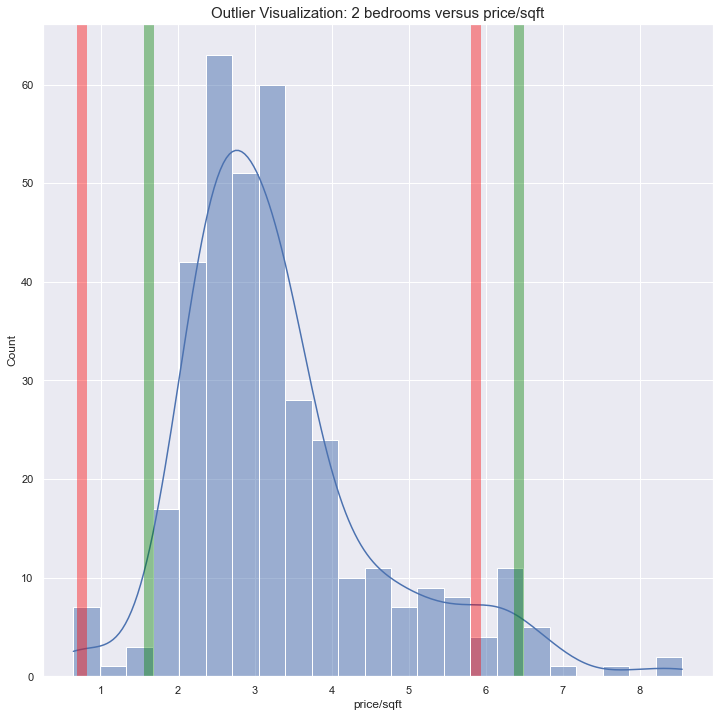

In [20]:
# Outlier plots for studios
beds = 2
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

In [21]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>1800) & (units.beds==2)].index, inplace=True)
units.drop(units[(units.rent>8000) & (units.beds==2)].index, inplace=True)


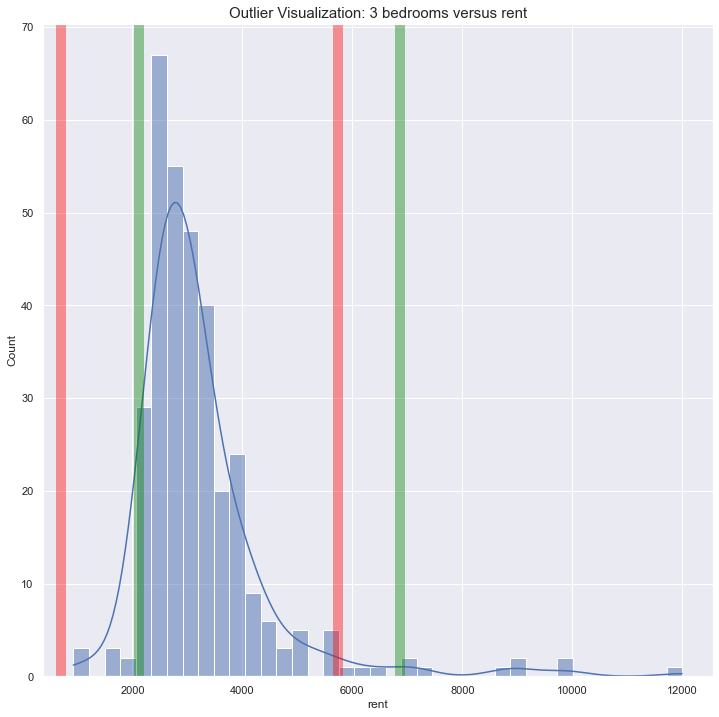

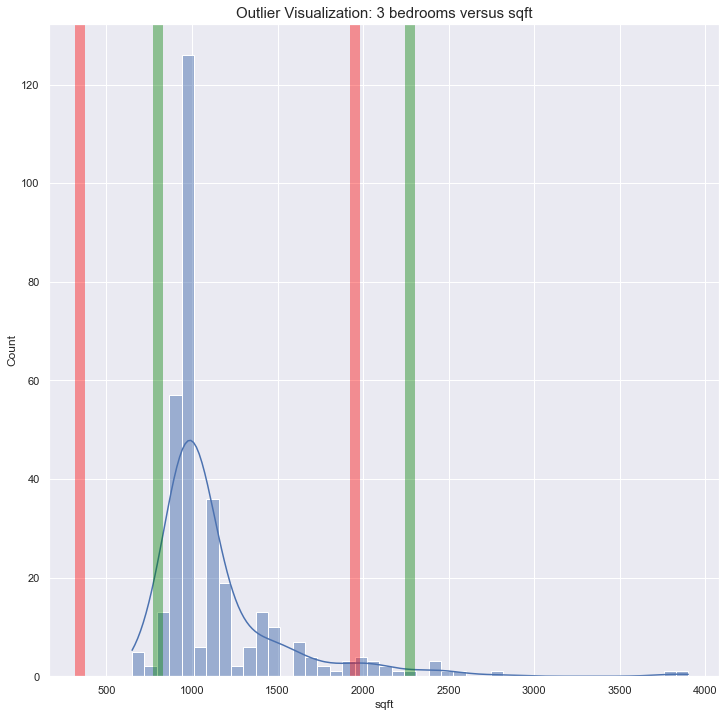

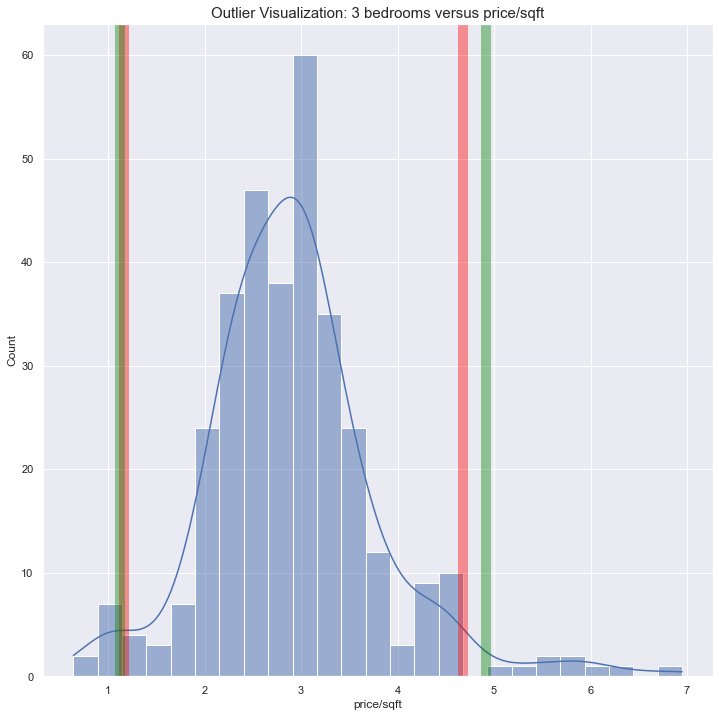

In [22]:
# Outlier plots for studios
beds = 3
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

In [23]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.rent>9000) & (units.beds==3)].index, inplace=True)

# Initial Exploration

### Skewness of rent and sqft columns

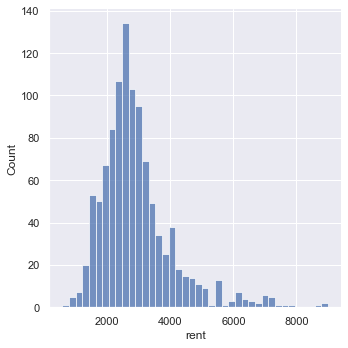

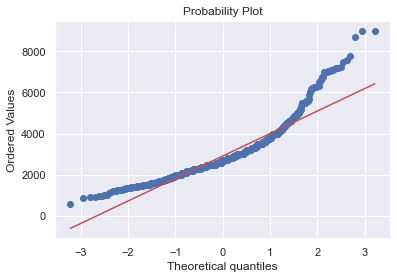

In [24]:
#Distribution of the rent column
sns.displot(units.rent)
fig = plt.figure()
res = stats.probplot(units.rent, plot=plt)

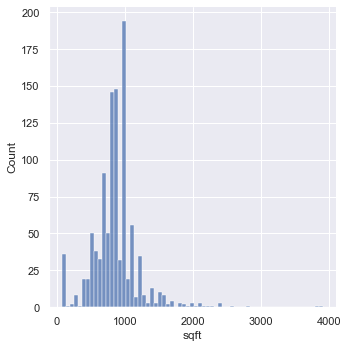

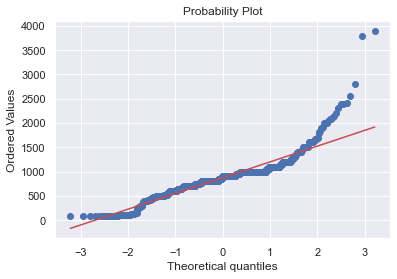

In [25]:
#Distribution of the sqft column
sns.displot(units.sqft)
fig = plt.figure()
res = stats.probplot(units.sqft, plot=plt)

### SQFT versus Rent

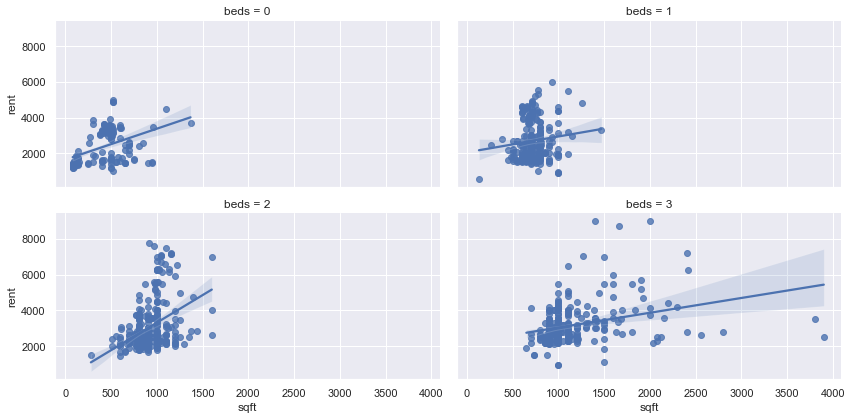

In [26]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'sqft','rent')

### Add location to waterfront, transit stops and midtown/wall street

In [27]:
# Load MTA Stop locations and clean to useable form
# Data comes in the form of: POINT(LAT LONG)
mta_stops = pd.read_csv('./data/external/mta_locations.csv')['the_geom']
mta_stops.replace('[POINT()]', '',regex=True, inplace=True)
mta_stops = mta_stops.str.strip()
mta_stops = pd.DataFrame(mta_stops.str.split(' ').to_list())
mta_stops.rename(columns={0:'lon', 1: 'lat'}, inplace=True)
mta_stops.lat=mta_stops.lat.astype(float)
mta_stops.lon=mta_stops.lon.astype(float)
mta_stops.drop_duplicates(inplace=True)
mta_stops.head()

,lon,lat
0,-73.868356,40.849169
1,-73.868213,40.849128
2,-73.873499,40.841223
3,-73.872892,40.841453
4,-73.879623,40.840815


In [28]:
# Calculate the nearest MTA stop for each listing
units['dist_transit']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, mta_stops.lat, mta_stops.lon).min(), axis=1)

In [29]:
# Define the locations of wall street and midtown
midtown = {'lat': 40.752148801459604, 'lon': -73.98749979654413}
wall_street = {'lat': 40.70773721622127, 'lon': -74.0101688916038}

units['dist_midtown']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, midtown['lat'], midtown['lon']), axis=1)
units['dist_wall_street']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, wall_street['lat'], wall_street['lon']), axis=1)

In [30]:
# with open('./data/external/borough_boundaries.geojson') as f:
#     manhattan_boundary = json.load(f)['features'][3]
    
# poly = Polygon([tuple(corr) for corr in manhattan_boundary['geometry']['coordinates'][33][0]])

# # Convert lat/long to point coordinates
# units['point']=units[['longitude', 'latitude']].apply(Point, axis=1)
# units['dist_waterfront']=units.point.apply(poly.exterior.distance)
# units.drop(columns={'point'}, inplace = True)
# units.head()

#### Plot Results

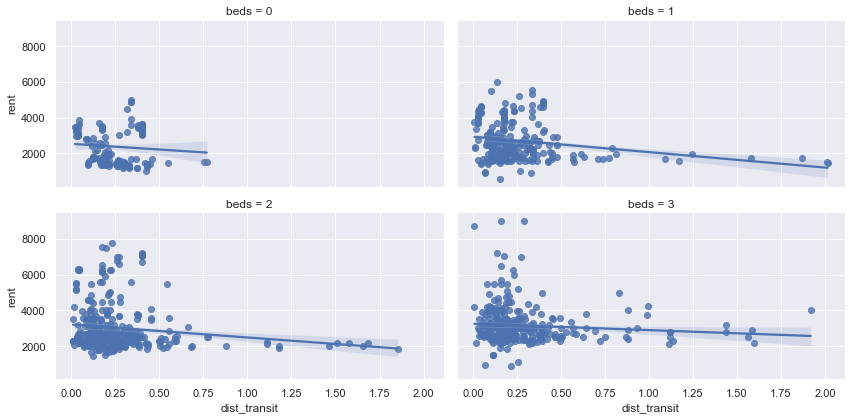

In [31]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_transit','rent')

In [55]:
# Visualize the relationship between price/sqft and distance to MTA stops

def transit_distance_plot(df):
 
    # Create distance bins based on distance to MTA stops
    # Look at binning for every 1/8th of a mile
    bins = np.arange(0.00, 1, 1/10)
    labels = bins[1:]
    df.loc[:,'transit_dist_bin'] = pd.cut(df.loc[:,"dist_transit"], bins=bins, labels=labels)
    
    # Create the boxplots
    plt.figure()
    sns.boxplot(x = 'transit_dist_bin', y = 'rent', data = df)
    plt.ylim(0,6000)
    plt.show()
    plt.close()

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



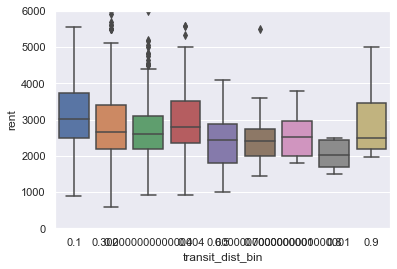

In [56]:
transit_distance_plot(units.copy())

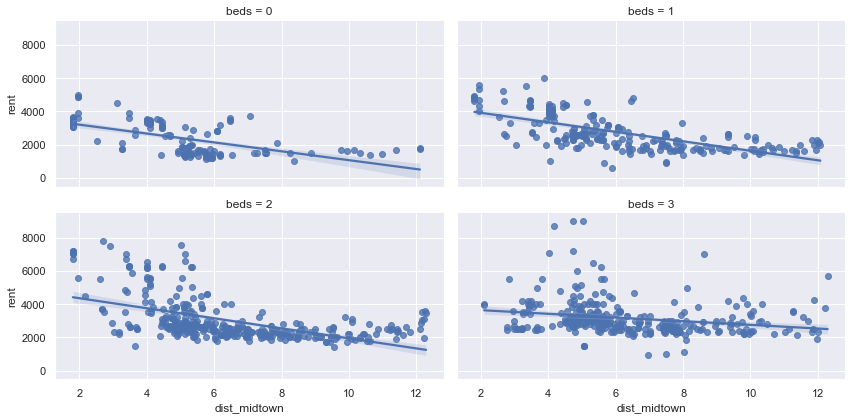

In [58]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_midtown','rent')

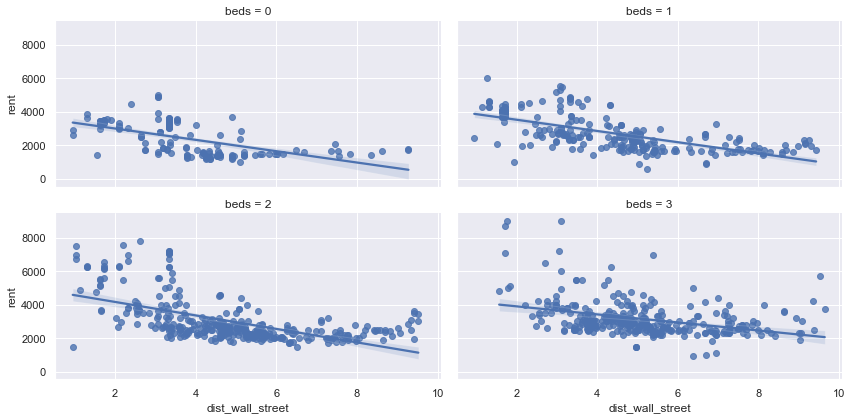

In [59]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_wall_street','rent')

* Both distance to midtown and wall street seem to exhibit similar trends. Since they're both redundant, we'll start with the distance to wall street as the main feature.

In [60]:
# Drop the two columns
units.drop(columns={'dist_midtown'}, inplace=True)

### Visualize binary features

In [61]:
units.columns

Index(['property_name', 'property_zipcode', 'unit_id', 'rent', 'beds', 'baths',
       'sqft', 'date_available', 'date_scraped', 'fitness_center',
       'air_conditioning', 'in_unit_washer_dryer', 'laundry_facilities',
       'car_charging', 'roof', 'concierge', 'pool', 'elevator', 'garage',
       'dogs_allowed', 'cats_allowed', 'income_restrictions', 'latitude',
       'longitude', 'neighborhood', 'zipcode', 'description',
       'unique_features', 'city_name', 'year_built', 'dishwasher',
       'property_url', 'price/sqft', 'dist_transit', 'dist_wall_street',
       'transit_dist_bin'],
      dtype='object')

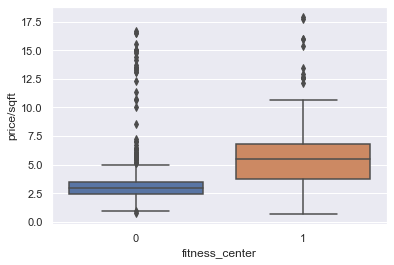

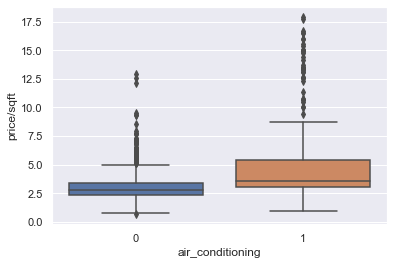

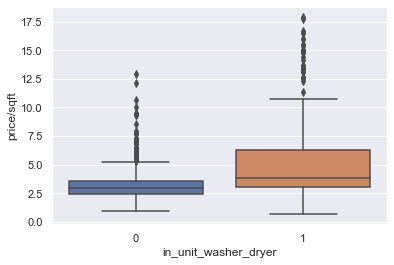

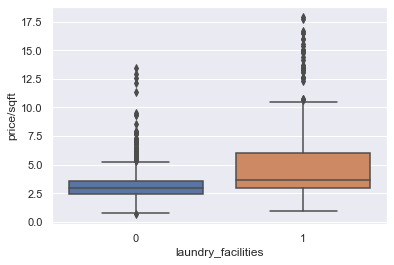

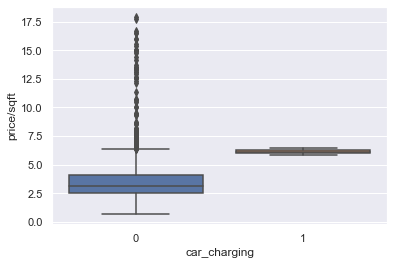

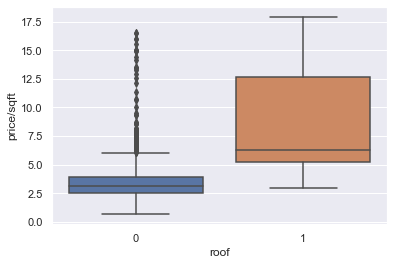

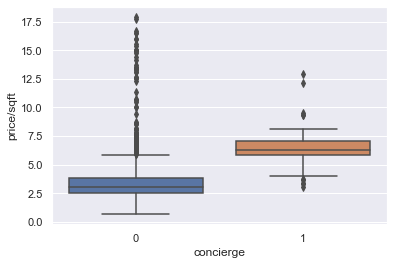

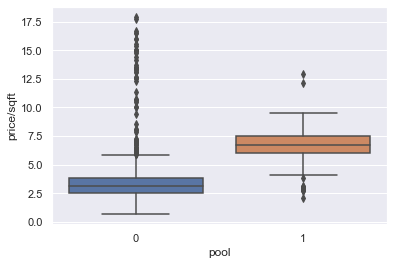

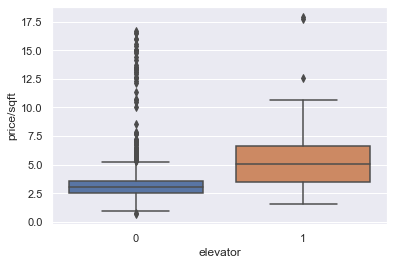

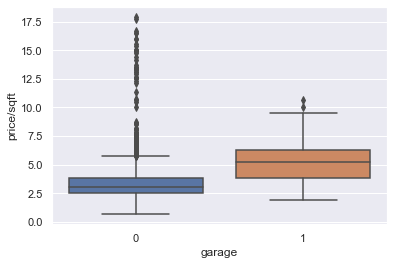

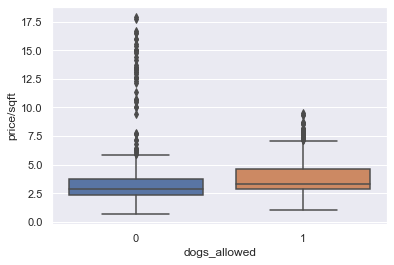

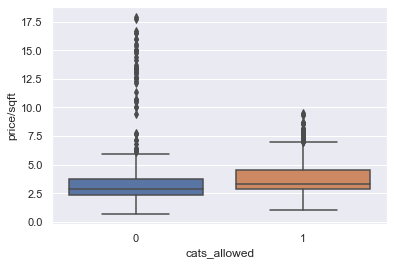

In [62]:
#plotting binary features
for i in units.columns[9:21]:
  plt.figure()
  sns.boxplot(x = i, y = 'price/sqft', data = units)
  plt.show()
  plt.close()

In [63]:
# Create new pets category
units['pets_allowed']=np.where((units.dogs_allowed == 1) | (units.cats_allowed == 1),
                               1,
                               0)

# Drop columns that are not necessary for further exploration
units.drop(columns={'dogs_allowed', 'cats_allowed', 'property_name', 'property_zipcode', 'unit_id', 'date_available', 'date_scraped', 'car_charging', 'neighborhood', 'zipcode', 'description', 'unique_features', 'city_name','year_built', 'property_url'}, inplace=True)

# Create new features from existing features

In [64]:
# Create two different columns that blend beds and baths together
units['beds_plus_baths'] = units.beds+units.baths
units['beds_times_baths'] = units.beds*units.baths

### Cluster the units based on the latitude/longitude

In [65]:
# Import K-means
from sklearn.cluster import KMeans

In [66]:
cluster_df = units.groupby(['latitude', 'longitude'], as_index=False)['price/sqft'].mean()
cluster_df.head()

,latitude,longitude,price/sqft
0,40.57530,-73.96803,3.789474
1,40.57558,-73.97332,2.818182
2,40.57564,-73.95886,3.000000
3,40.57568,-73.95881,2.760000
4,40.57639,-73.96152,2.166667


In [67]:
# Compute the elbow curve to determine the optimal number of clusters

def optimal_cluster():
    # Find the optimal number of clusters to use
    K_clusters = range(5,50)
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    sse =[]

    for k in K_clusters:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(lat_long, sample_weight=weights)
        sse.append(kmeans.inertia_)


    plt.plot(K_clusters, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Curve')
    plt.show()

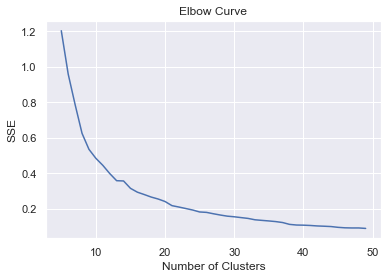

In [68]:
optimal_cluster()

Around 35ish clusters there appears to be an elbow forming. We'll explore using 38 clusters and visualize the clusters on a map.

In [69]:
def clusters(clusters:int):
    # Find the optimal number of clusters to use
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    
    kmeans = KMeans(n_clusters=clusters, **kmeans_kwargs)
    kmeans.fit(lat_long, sample_weight=weights)
    return kmeans

In [70]:
# Assign clusters to units
kmeans = clusters(38)
units['cluster_id'] = kmeans.predict(units[['latitude','longitude']])

In [71]:
fig = px.scatter_mapbox(units, lat="latitude", lon="longitude", color="cluster_id", mapbox_style="carto-positron", zoom=11.3)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [72]:
# Target encode the cluster id with the price/sqft mean of the cluster
# This will need to be re-done after the test-train split to avoid data leakage
# For now its computed on the whole set to visualize the correlation
units['cluster_id_encoded']=units.cluster_id.map(units.groupby('cluster_id')['price/sqft'].mean())

# Produce a correlation map

<AxesSubplot:>

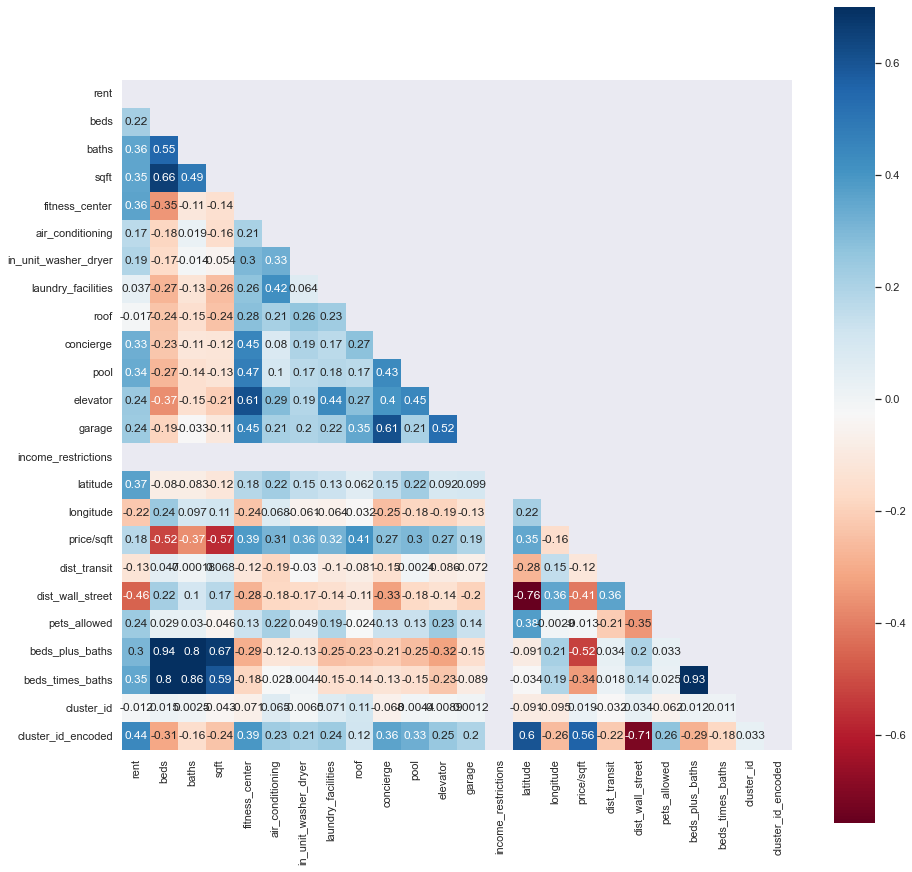

In [75]:
corr_map = units.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_map, dtype=bool))

f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr_map, square = True, vmax = 0.7, cmap = 'RdBu', annot = True, mask = mask)

The cluster_id_encoded column has a fairly strong correlation with the rent so we'll use that feature instead of the cluster_id

In [76]:
# Drop remaining columns
units.drop(columns={'beds', 'baths', 'beds_plus_baths','income_restrictions', 'price/sqft', 'cluster_id', 'cluster_id_encoded'}, inplace=True)

In [77]:
units.head()

,rent,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,latitude,longitude,dishwasher,dist_transit,dist_wall_street,transit_dist_bin,pets_allowed,beds_times_baths
1,4060.0,684.0,1,1,1,1,0,1,0,1,1,40.69273,-73.98605,1,0.026536,1.634417,0.1,1,1.0
2,3005.0,469.0,1,1,1,1,0,1,0,1,1,40.69273,-73.98605,1,0.026536,1.634417,0.1,1,0.0
5,5122.0,976.0,1,1,1,1,0,1,0,1,1,40.69273,-73.98605,1,0.026536,1.634417,0.1,1,4.0
8,4349.0,618.0,1,1,1,1,0,1,0,1,1,40.69273,-73.98605,1,0.026536,1.634417,0.1,1,1.0
9,3981.0,675.0,1,1,1,1,0,1,0,1,1,40.69273,-73.98605,1,0.026536,1.634417,0.1,1,1.0


# Save the data for modeling

In [100]:
units.to_csv('./data/processed/brooklyn_04-20-2022.csv', index=False)